In [1]:
import pandas as pd
import numpy as np
import csv

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.tokenize import word_tokenize
# nltk.download('punkt')

import spacy

In [2]:
# Load data frames
df_train = pd.read_csv('train.csv', sep=',')
df_test = pd.read_csv('test.csv', sep=',')

print('Training Set shape = {}'.format(df_train.shape))
print('Test Set shape = {}'.format(df_test.shape))

Training Set shape = (7613, 5)
Test Set shape = (3263, 4)


In [3]:
# Explore data set
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


Observation :

This is a binary classification project, target is whether 0 or 1. The mean for target is ~ 0.43, so the number of examples for each class is different.
Let's evaluate the class distribution :

# Data visualization

In [5]:
# data visualization

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#plt.style.use('ggplot')
sns.set_theme()

In [6]:
# You can set parameters for all the plots, instead of having to set them in every cell :

'''
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)

Or :

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title
''';

### Class distribution

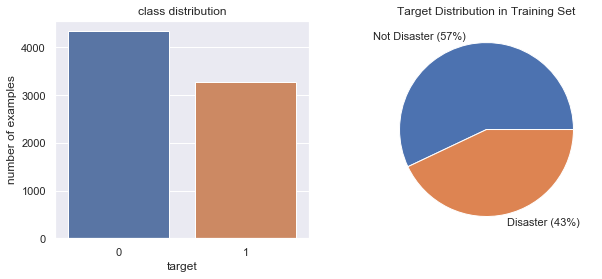

In [7]:
customized_palette = [sns.color_palette()[0], sns.color_palette()[1]] # blue for false disasters and green for real disasters

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.barplot(x=df_train['target'].value_counts().index,
            y=df_train['target'].value_counts(),
            palette=customized_palette,
            ax=axes[0])

# Quicker method :
# sns.countplot(x=df_train['target'])

axes[0].set(xlabel='target', ylabel='number of examples', title='class distribution')
# Other method
# plt.gca().set_ylabel('number of examples') # gca = get current axis

df_train.groupby('target').count()['id'].plot(kind='pie', labels=['Not Disaster (57%)', 'Disaster (43%)'], ax=axes[1])
axes[1].set(ylabel='', title='Target Distribution in Training Set')

plt.show()

In [8]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Amongst a total of 7613 tweets, 3271 are about a real disaster (43%), and 4342 aren't (57%).

### Missing values in 'keyword' and 'location' features

In [9]:
print(f'{df_train["keyword"].nunique()} unique keyword values in the training set and {df_test["keyword"].nunique()} in the test set')
print(f'{df_train["location"].nunique()} unique location values in the training set and {df_test["location"].nunique()} in the test set')

221 unique keyword values in the training set and 221 in the test set
3341 unique location values in the training set and 1602 in the test set


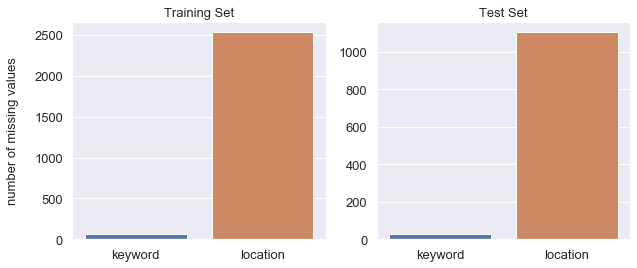

In [10]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))


sns.barplot(x=df_train[missing_cols].isnull().sum().index,
            y=df_train[missing_cols].isnull().sum().values,
            ax=axes[0],
            palette=customized_palette)

sns.barplot(x=df_test[missing_cols].isnull().sum().index,
            y=df_test[missing_cols].isnull().sum().values,
            ax=axes[1],
            palette=customized_palette)

axes[0].set_ylabel('number of missing values', fontsize=13, labelpad=15)
axes[0].tick_params(axis='both', labelsize=13)
axes[0].set_title('Training Set', fontsize=13)

axes[1].tick_params(axis='both', labelsize=13)
axes[1].set_title('Test Set', fontsize=13)


plt.show()

'''
We could replace the missing values by 'no_keyword' and 'no_location' using the fillna() method, as follows :

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')
''';

### 'keyword' values class distribution

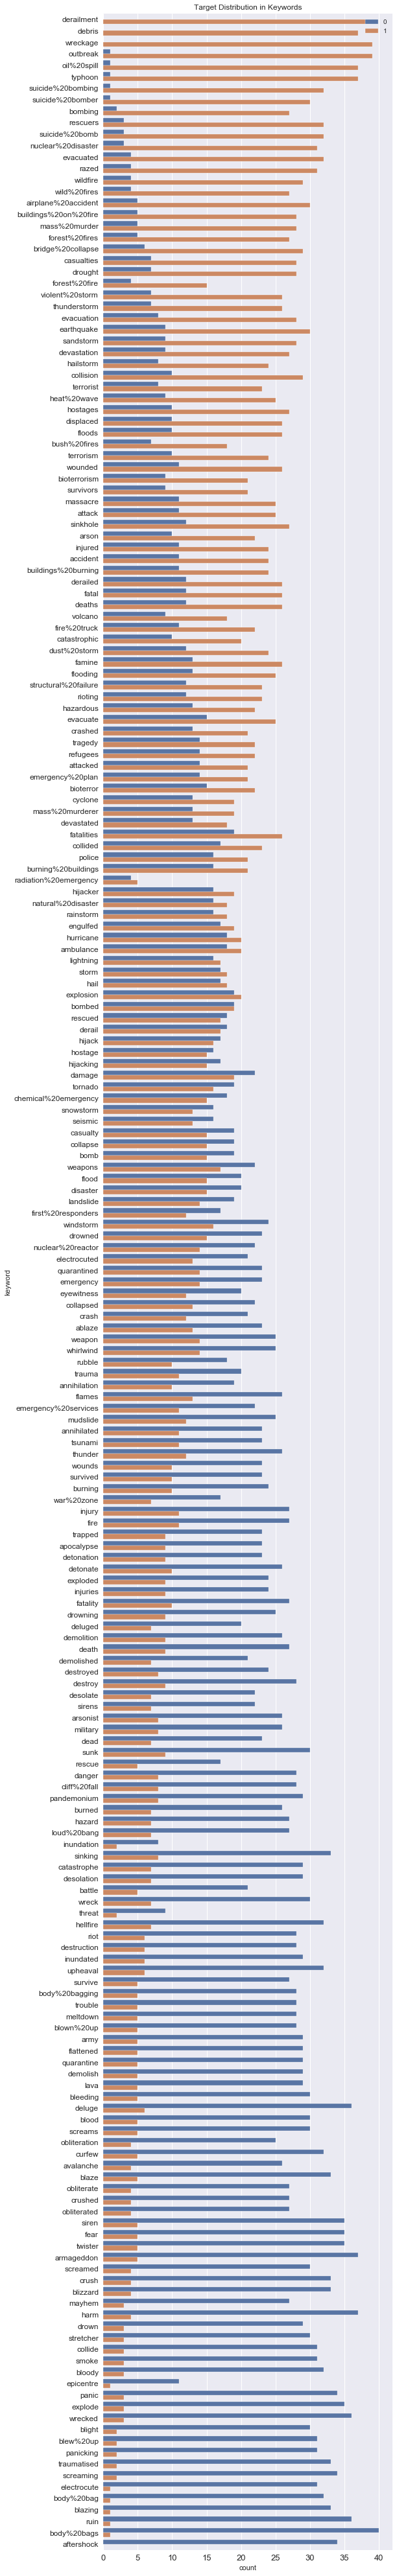

In [33]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

plt.figure(figsize=(8, 72))

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'],
              palette=customized_palette)

plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

### Number of characters in tweets

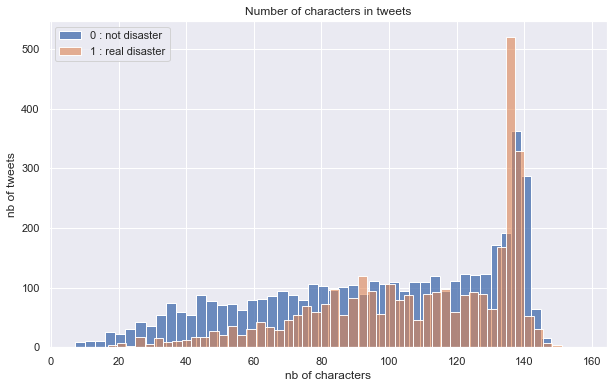

In [12]:
plt.figure(figsize=(10,6))

df_tweets_len = df_train[df_train['target']==0]['text'].apply(len) # we use the .apply() method, therefore vectorization, for computational time purposes

# other method :
# tweet_len=df_train[df_train['target']==0]['text'].str.len()

sns.histplot(x=df_tweets_len, bins=50, color=customized_palette[0], label='0 : not disaster', alpha=0.8)

df_tweets_len = df_train[df_train['target']==1]['text'].apply(len)

sns.histplot(x=df_tweets_len, bins=50, color=customized_palette[1], label='1 : real disaster', alpha=0.6)

plt.title('Number of characters in tweets')
plt.xlabel('nb of characters')
plt.ylabel('nb of tweets')
plt.legend(loc='upper left')
plt.show()

Observation :

I guess most of the dataset was built when tweets could only contain up to 140 characters, and not 280 like today. (Very few have more than 140 chars, max for not disaster tweets is 157 chars, and max for real disaster tweets is 151 chars)\
The trends are pretty similar for the 2 classes, both having a peak of tweets containing [130,145] characters, close or equal to the max.

##### Analyzing this [130,145] space

In [13]:
df_tweets_len = df_train[df_train['target']==0]['text'].apply(len)
df_tweets_140_chars = df_tweets_len[(df_tweets_len>130) & (df_tweets_len<145)]
print("Amongst {} 'not disaster tweets', {} % (i.e. {} tweets) contain between 130 and 145 characters.".format(df_tweets_len.shape[0], round((100*df_tweets_140_chars.shape[0]/df_tweets_len.shape[0]),1), df_tweets_140_chars.shape[0]))

df_tweets_len = df_train[df_train['target']==1]['text'].apply(len)
df_tweets_140_chars = df_tweets_len[(df_tweets_len>130) & (df_tweets_len<145)]
print("Amongst {} 'real disaster tweets', {} % (i.e. {} tweets) contain between 130 and 145 characters.".format(df_tweets_len.shape[0], round((100*df_tweets_140_chars.shape[0]/df_tweets_len.shape[0]),1), df_tweets_140_chars.shape[0]))

Amongst 4342 'not disaster tweets', 23.5 % (i.e. 1021 tweets) contain between 130 and 145 characters.
Amongst 3271 'real disaster tweets', 34.5 % (i.e. 1130 tweets) contain between 130 and 145 characters.


Taking into account the number of samples for each class, 'real disaster tweets' are more likely to contain near or exactly the maximum number of characters allowed than 'not disaster tweets'.

### Number of words in tweets

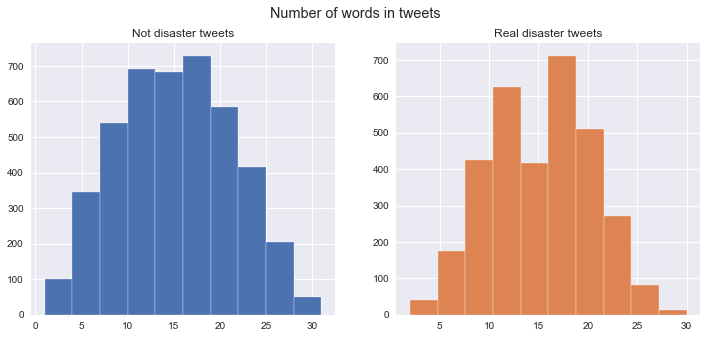

In [14]:
plt.style.use('seaborn')

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

df_tweets_len = df_train[df_train['target']==0]['text'].str.split().apply(len)

# other method :
# df_tweets_len = df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))

ax1.hist(df_tweets_len, color=customized_palette[0])
ax1.set_title('Not disaster tweets')

df_tweets_len = df_train[df_train['target']==1]['text'].str.split().apply(len)

ax2.hist(df_tweets_len, color=customized_palette[1])
ax2.set_title('Real disaster tweets')

fig.suptitle('Number of words in tweets')
plt.show()

Observation :

Again, the trends are pretty similar for the 2 classes, with most of the tweets containing [7,22] words.

### Average length of words in each tweet

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



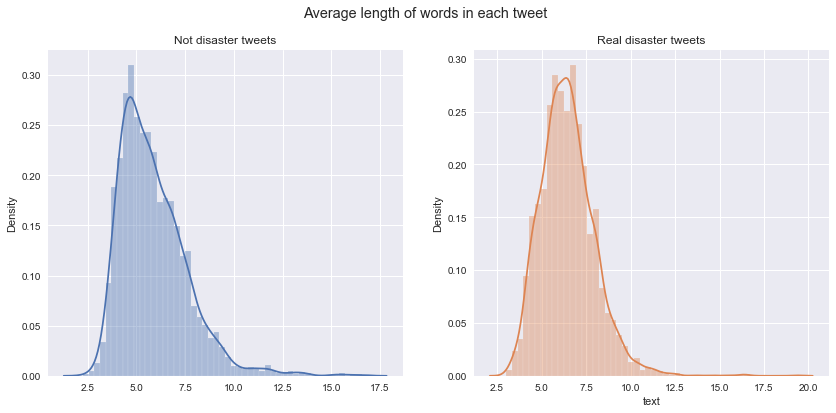

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(14,6))

df_len_words = df_train[df_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(x=df_len_words.map(lambda x: np.mean(x)),
             ax=ax1,
             color=customized_palette[0])
ax1.set_title('Not disaster tweets')

df_len_words = df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(df_len_words.map(lambda x: np.mean(x)),
             ax=ax2,
             color=customized_palette[1])
ax2.set_title('Real disaster tweets')

fig.suptitle('Average length of words in each tweet')
plt.show()

Observation :

The 2 classes show a very slight difference.\
Most of the 'not disaster tweets' contain words having [3,7] characters, while 'real disaster tweets' seem to contain words having [5,7.5] characters.\
Therefore, it seems that the words for the 2nd class are a bit longer.

##### The mean number of characters among the whole dataset

In [16]:
df_mean_len_words = df_train[df_train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
print("In average, a word in a 'not disaster tweet' contains {} characters.".format(round(df_mean_len_words.mean(),2)))

df_mean_len_words = df_train[df_train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
print("In average, a word in a 'real disaster tweet' contains {} characters.".format(round(df_mean_len_words.mean(),2)))

In average, a word in a 'not disaster tweet' contains 5.87 characters.
In average, a word in a 'real disaster tweet' contains 6.47 characters.


Our previous suspicion is verified : in average, the words in the 'real disaster tweets' are longer.

### Most common stop words

In [17]:
# It would have been interesting here to create a corpus if we plan to do differents analysis instead of going over the
# dataset multiple times.
'''
def create_corpus(target):
    corpus=[]
    
    for tweet in df_train[df_train['target']==target]['text'].str.split():
        for word in tweet:
            corpus.append(word)
    return corpus
    
corpus_class0 = create_corpus(0)
''';

In [18]:
import nltk
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))


# For class 0 : 'not disaster tweets'

dict_stopwords_class0 = {key:0 for key in list(stop_words)}

for tweet in df_train[df_train['target']==0]['text'].str.split() :
    for word in tweet :
        if (word in stop_words) :
            dict_stopwords_class0[word] += 1
            
most_common_stopwords = sorted(dict_stopwords_class0.keys(), key=lambda x : dict_stopwords_class0[x], reverse=True)[:10]

dict_stopwords_class0 = {key:dict_stopwords_class0[key] for key in most_common_stopwords}
print('Most common stop words in class 0 :\n', dict_stopwords_class0)


# For class 1 : 'real disaster tweets'

dict_stopwords_class1 = {key:0 for key in list(stop_words)}

for tweet in df_train[df_train['target']==1]['text'].str.split() :
    for word in tweet :
        if (word in stop_words) :
            dict_stopwords_class1[word] += 1
            
most_common_stopwords = sorted(dict_stopwords_class1.keys(), key=lambda x : dict_stopwords_class1[x], reverse=True)[:10]

dict_stopwords_class1 = {key:dict_stopwords_class1[key] for key in most_common_stopwords}
print('\nMost common stop words in class 1 :\n', dict_stopwords_class1)

Most common stop words in class 0 :
 {'the': 1524, 'a': 1115, 'to': 1099, 'and': 840, 'of': 834, 'in': 720, 'you': 529, 'is': 512, 'for': 452, 'my': 442}

Most common stop words in class 1 :
 {'the': 1051, 'in': 1037, 'of': 888, 'a': 730, 'to': 706, 'and': 462, 'on': 386, 'for': 368, 'is': 302, 'at': 273}


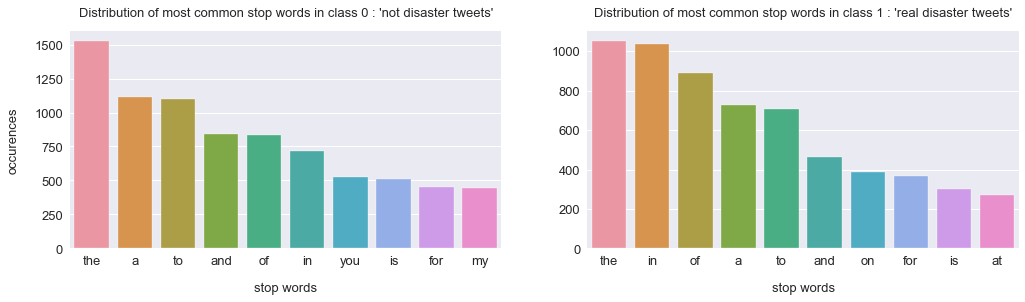

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 4))


ax0 = sns.barplot(x=list(dict_stopwords_class0.keys()),
                  y=list(dict_stopwords_class0.values()),
                  ax=axes[0])

ax0.set_xlabel('stop words', fontsize=13, labelpad=15)
ax0.set_ylabel('occurences', fontsize=13, labelpad=15)
ax0.tick_params(axis='both', labelsize=13) # 'axis' parameter is already 'both' by default, it's just to understand that we can specify 'x' or 'y'
ax0.set_title('Distribution of most common stop words in class 0 : \'not disaster tweets\'', fontsize=13, pad=15)

# other method for quicker plots :
# ax0.set(xlabel='stop words',
#         ylabel='occurences',
#         title='Distribution of most common stop words in class 0 : \'not disaster tweets\'')
# ax0.xaxis.label.set_size(13)


ax1 = sns.barplot(x=list(dict_stopwords_class1.keys()),
                  y=list(dict_stopwords_class1.values()),
                  ax=axes[1])

ax1.set_xlabel('stop words', fontsize=13, labelpad=15)
#ax1.set_ylabel('occurences', fontsize=13, labelpad=15) # not necessary to repeat this label
ax1.tick_params(axis='both', labelsize=13)
ax1.set_title('Distribution of most common stop words in class 1 : \'real disaster tweets\'', fontsize=13, pad=15)


plt.show()

Observation :

'The' dominates the ranking for both classes.\
Stop words are usually considered as meaningless data: not containing useful information to help classifying the tweets.\
Removing them also improves the processing time.\
We will see how we deal with them further in the notebook.

### Homemade preprocessing analysis

In [20]:
from homemade_preprocessing import Tokenizer

# For class 0 : 'not disaster tweets'

corrections_class0 = Tokenizer()

for tweet in df_train[df_train['target']==0]['text'].str.split() :
    for word in tweet :
        corrections_class0.test_word(word)

print('Corrections in class 0 :\n', corrections_class0._result)


# For class 1 : 'real disaster tweets'

corrections_class1 = Tokenizer()

for tweet in df_train[df_train['target']==1]['text'].str.split() :
    for word in tweet :
        corrections_class1.test_word(word)

print('\nCorrections in class 1 :\n', corrections_class1._result)

Corrections in class 0 :
 {'tag': 1798, 'hashtag': 1683, 'laughs': 47, 'smileys': 14, 'extensions': 0, 'website': 2196, 'time': 40, 'date': 3, 'mail': 1}

Corrections in class 1 :
 {'tag': 872, 'hashtag': 1691, 'laughs': 14, 'smileys': 4, 'extensions': 0, 'website': 2510, 'time': 92, 'date': 20, 'mail': 0}


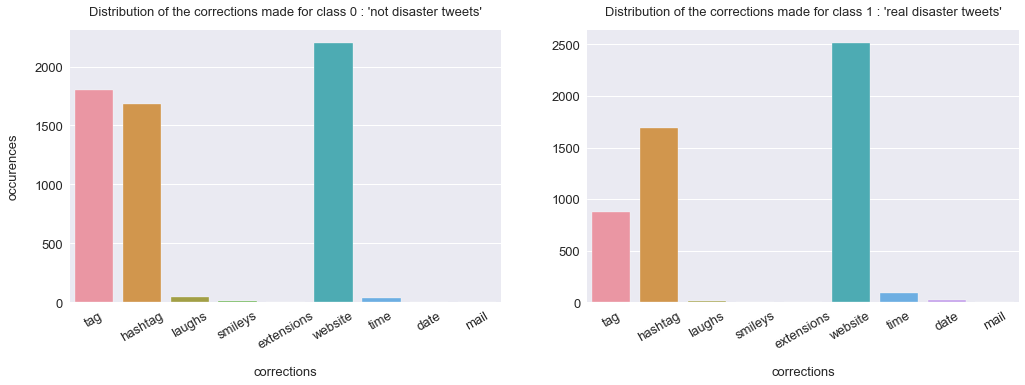

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))


ax0 = sns.barplot(x=list(corrections_class0._result.keys()),
                  y=list(corrections_class0._result.values()),
                  ax=axes[0])

ax0.set_xlabel('corrections', fontsize=13, labelpad=15)
ax0.set_ylabel('occurences', fontsize=13, labelpad=15)
ax0.tick_params(labelsize=13)
ax0.tick_params(axis='x', labelrotation=30)
ax0.set_title('Distribution of the corrections made for class 0 : \'not disaster tweets\'', fontsize=13, pad=15)


ax1 = sns.barplot(x=list(corrections_class1._result.keys()),
                  y=list(corrections_class1._result.values()),
                  ax=axes[1])

ax1.set_xlabel('corrections', fontsize=13, labelpad=15)
ax1.tick_params(labelsize=13)
ax1.tick_params(axis='x', labelrotation=30)
ax1.set_title('Distribution of the corrections made for class 1 : \'real disaster tweets\'', fontsize=13, pad=15)


plt.show()

Observations :

The corrections may vary a bit depending on the tokenization method we adopt. The homemade_preprocessing script was built for a tokenization using the .split() method, which considers 'fire.' as 1 token, while word_tokenization() from nltk or SpaCy would consider 2 tokens 'fire' and '.' .\
We can see that a lot of tweets contain tags (ex : '@johnHarris'), hashtags (ex : #blablabla) and websites (ex : http://t.co/gibberish). \
No corrections seem to be very different from a class to another, except maybe for tags that seem to appear more often in class 0, and websites that seem to appear more often in real disasters, which could make sense : users would want to link more 'reliable' sources to their tweets claiming a disaster is going on.<br><br>
Some other minor corrections were made, like laughs (ex : hahaha) (see the homemade_preprocessing.py file for more details).

### Most common words

In [22]:
from collections import  Counter

def create_corpus(target):
    corpus = []
    
    for tweet in (df_train[df_train['target']==target]['text'].str.split()) :
        for word in tweet:
            corpus.append(word)
    return corpus

In [23]:
# class 0

corpus_class0 = create_corpus(0)

counter = Counter(corpus_class0)
counter_most_common = counter.most_common()

unigram0 = []
count0 = []
i = 0
n_most = 30
while len(unigram0)<n_most :
    word = counter_most_common[i][0]
    count = counter_most_common[i][1]
    if (word not in stop_words) :
        unigram0.append(word)
        count0.append(count)
    i+=1

    
# class 1

corpus_class1 = create_corpus(1)

counter = Counter(corpus_class1)
counter_most_common = counter.most_common()

unigram1 = []
count1 = []
i = 0
while len(unigram1)<n_most :
    word = counter_most_common[i][0]
    count = counter_most_common[i][1]
    if (word not in stop_words) :
        unigram1.append(word)
        count1.append(count)
    i+=1

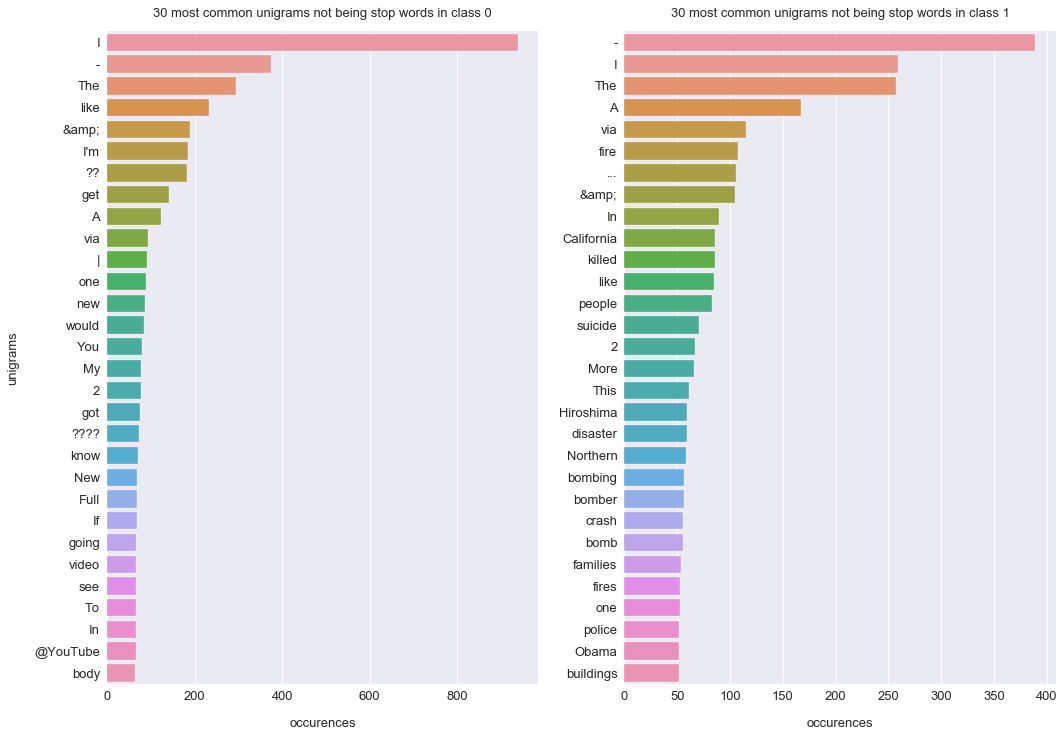

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 12))

ax0 = sns.barplot(x=count0, y=unigram0, ax=axes[0])

ax0.set_xlabel('occurences', fontsize=13, labelpad=15)
ax0.set_ylabel('unigrams', fontsize=13, labelpad=15)
ax0.tick_params(labelsize=13)
ax0.set_title(f'{n_most} most common unigrams not being stop words in class 0', fontsize=13, pad=15)

ax1 = sns.barplot(x=count1, y=unigram1, ax=axes[1])

ax1.set_xlabel('occurences', fontsize=13, labelpad=15)
ax1.tick_params(labelsize=13)
ax1.set_title(f'{n_most} most common unigrams not being stop words in class 1', fontsize=13, pad=15)

plt.show()

Observation :

We see a difference here.<br/>
The top 10 in both classes are mostly stop words that went through the filter but after that, most common unigrams for non disaster tweets (0) are mostly common verbs or words without a significant meaning for our usecase while most common unigrams for real disaster tweets (1) already give some information about the disaster (killed, bomb, fire, disaster, etc.)

### Most common bi-grams

In [25]:
def create_corpus_bigrams(target):
    corpus = []
    
    for tweet in (df_train[df_train['target']==target]['text'].str.split()) :
        for i in range (len(tweet) - 1) :
            corpus.append( (tweet[i],tweet[i+1]) )
    return corpus

In [26]:
# class 0

corpus_bigrams_class0 = create_corpus_bigrams(0)

counter = Counter(corpus_bigrams_class0)
counter_most_common = counter.most_common()

bigrams0 = []
count0 = []
i = 0
n_most = 30
while len(bigrams0)<n_most :
    bigram = counter_most_common[i][0]
    count = counter_most_common[i][1]
    if (bigram[0] not in stop_words) or (bigram[1] not in stop_words) :
        bigrams0.append(bigram[0] + ' ' + bigram[1])
        count0.append(count)
    i+=1
    

# class 1

corpus_bigrams_class1 = create_corpus_bigrams(1)

counter = Counter(corpus_bigrams_class1)
counter_most_common = counter.most_common()

bigrams1 = []
count1 = []
i = 0
while len(bigrams1)<n_most :
    bigram = counter_most_common[i][0]
    count = counter_most_common[i][1]
    if (bigram[0] not in stop_words) or (bigram[1] not in stop_words) :
        bigrams1.append(bigram[0] + ' ' + bigram[1])
        count1.append(count)
    i+=1

'''
Other method from internet, using CountVectorizer() from sklearn (not tested) :

from sklearn.feature_extraction.text import CountVectorizer

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus) # corpus of single words
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)
''';

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning:

Glyph 137 missing from current font.

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning:

Glyph 137 missing from current font.



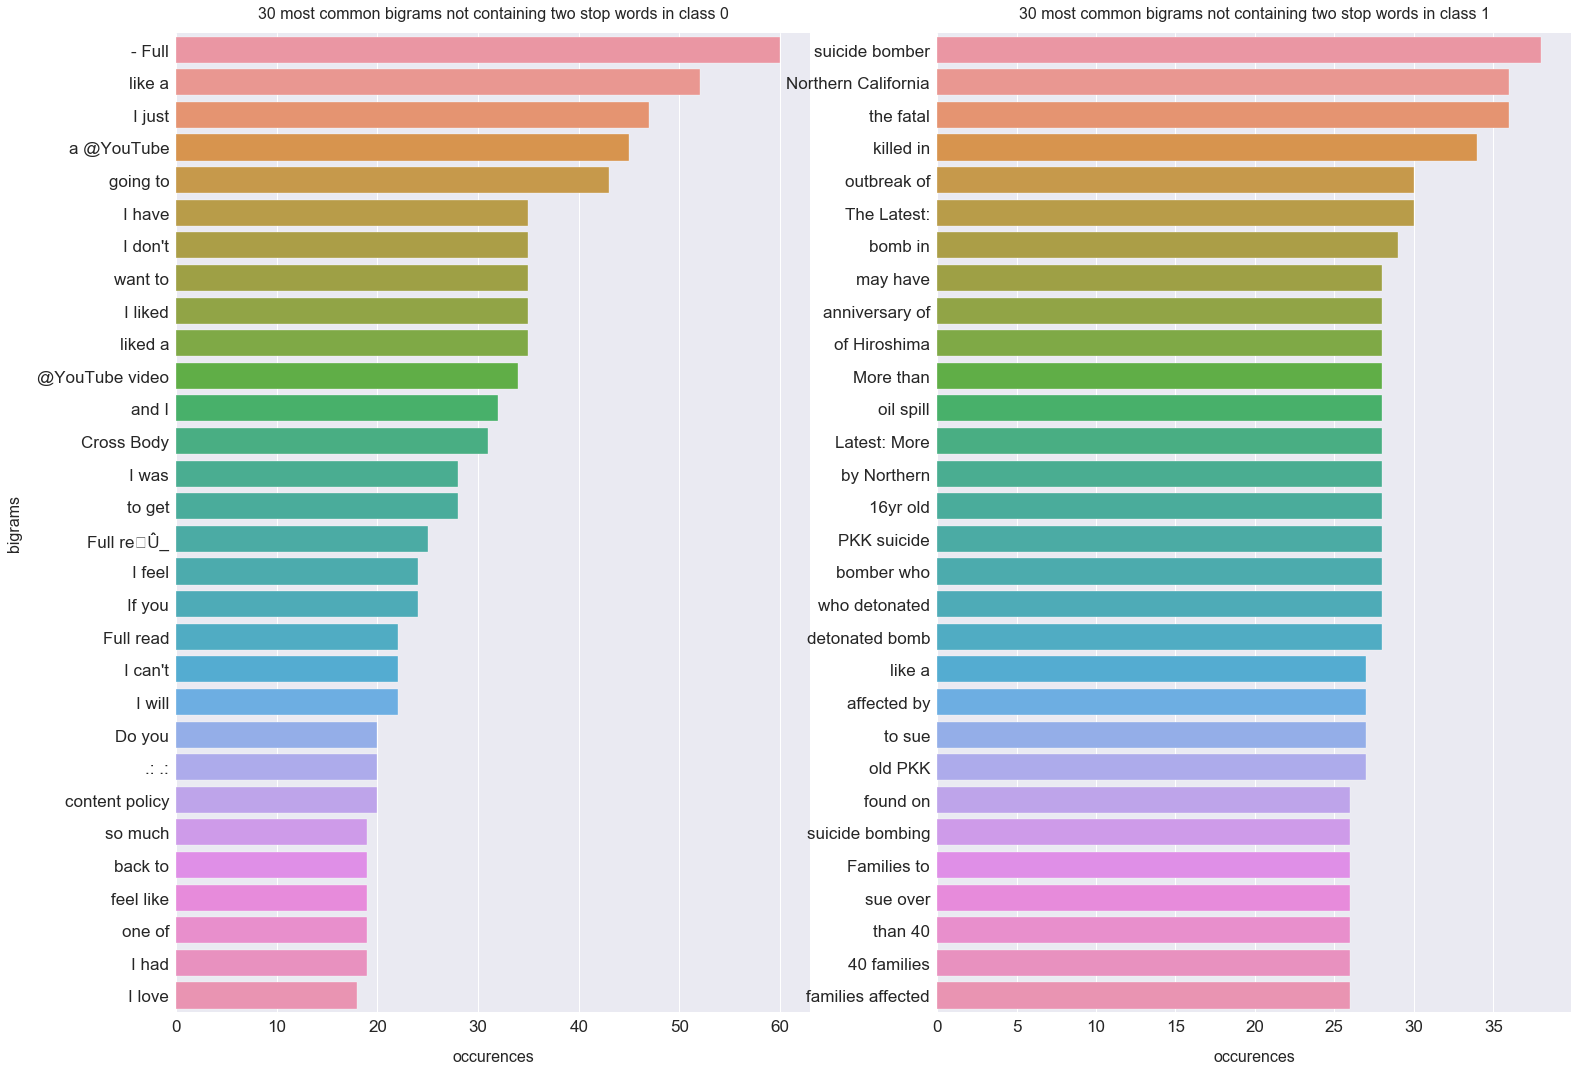

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 18))

ax0 = sns.barplot(x=count0, y=bigrams0, ax=axes[0])

ax0.set_xlabel('occurences', fontsize=16, labelpad=15)
ax0.set_ylabel('bigrams', fontsize=16, labelpad=15)
ax0.tick_params(labelsize=17)
ax0.set_title(f'{n_most} most common bigrams not containing two stop words in class 0', fontsize=16, pad=15)

ax1 = sns.barplot(x=count1, y=bigrams1, ax=axes[1])

ax1.set_xlabel('occurences', fontsize=16, labelpad=15)
ax1.tick_params(labelsize=17)
ax1.set_title(f'{n_most} most common bigrams not containing two stop words in class 1', fontsize=16, pad=15)

plt.show()

Observation :

We see a clear difference here.<br/>
Most common bigrams for non disaster tweets (0) are mostly common verbs at the 1st person of singular (I + vrb) and they don't contain meaning about any disaster, while most common bigrams for real disaster tweets (1) give some information about the disaster (suicide, bomb, detonated, etc.)

# Data cleaning

We're now going to build our own test set so we don't need to submit to Kaggle to have an overview of our model performances.
We only have 7613 examples, so we'll take 20% of the entire dataset for the testset.

In [62]:
X = df_train.drop('target', axis=1)
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head(10)

,id,keyword,location,text
4996,7128,military,Texas,Courageous and honest analysis of need to use ...
3263,4688,engulfed,NaN,@ZachZaidman @670TheScore wld b a shame if tha...
4907,6984,massacre,Cottonwood Arizona,Tell @BarackObama to rescind medals of 'honor'...
2855,4103,drought,"Spokane, WA",Worried about how the CA drought might affect ...
4716,6706,lava,"Medan,Indonesia",@YoungHeroesID Lava Blast &amp; Power Red #Pan...
7538,10777,wreckage,NaN,Wreckage 'Conclusively Confirmed' as From MH37...
3172,4551,emergency%20plan,Ireland,Our builder is having a dental emergency. Whic...
3932,5590,flood,NaN,BMX issues Areal Flood Advisory for Shelby [AL...
5833,8334,rubble,Made Here In Detroit,#360WiseNews : China's Stock Market Crash: Are...
7173,10278,war%20zone,NaN,@RobertONeill31 Getting hit by a foul ball whi...


We now have 6090 examples for our train set, and 1523 examples for the test set.

In [59]:
'''
# Preprocessing

from nltk.tokenize import word_tokenize
# nltk.download('punkt')

nlp = spacy.load("en_core_web_md", disable=["parser", "ner"])

homemade_tokenizer = Tokenizer()

for i in range (len(X_train)):
    if (i%1000 == 0):
        print(i, 'off', len(X_train))
    tweet = X_train.iloc[i]['text']
    
    # 1. lowercase (to reduce the vocabulary size)
    
    tweet = tweet.lower()
    
    
    # 2. remove stop words using list from nltk (considered as useless data and to improve processing time)
    
    tweet_split_processed = [word for word in tweet.split() if not word in stop_words]
    #tweet = ' '.join(tweet_split_processed)
    
    # 3. lemmatization using spacy
    
    for j in range (len(tweet_split_processed)) :
        doc = nlp(tweet_split_processed[j])
        for token in doc:
            if (token.text != token.lemma_) :
                tweet_split_processed[j] = token.lemma_
        
        # 4. homemade preprocessing to identify websites, hashtags, person tags, etc.
        
        tweet_split_processed[j] = homemade_tokenizer.test_word(tweet_split_processed[j])
        
    
    # add changes to dataset
    X_train.at[X_train.index[i],'text'] = ' '.join(tweet_split_processed)

   
    
#TODO : homemade_tokenizer se fait sur le tweet.split() et non après tokenization --> moins efficace ?
#       lemmatization sur tokenization peut créer des problemes quand len(tweet_split_processed[j]) != len(doc). Ex '1945.'
#       Example concret dans 2ème tweet ou 'flames.' devient 'flame', pareil 4eme tweet 'you?' devient '-PRON-'

                
    #print(' '.join(tweet_split_processed))
    #print('\n\n')
''';

In [63]:
# Create features set (vectorization)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(lowercase=False, use_idf=True, ngram_range=(1,1))
X_train_features = tfidf_vectorizer.fit_transform(X_train['text'])

tfidf_vectorizer_test = TfidfVectorizer(lowercase=False, use_idf=True, ngram_range=(1,1), vocabulary=tfidf_vectorizer.vocabulary_)
X_test_features = tfidf_vectorizer_test.fit_transform(X_test['text'])

print('vocabulary size : ', len(tfidf_vectorizer.vocabulary_))

vocabulary size :  22138


# Models

### Baseline model

In [98]:
#y_pred = np.random.randint(2, size=len(y_test))
y_pred = np.random.choice([0,1], p=[0.57, 0.43], size=len(y_test))
print("[baseline model] f1 score : {}".format(round(f1_score(y_test, y_pred), 2)))

[baseline model] f1 score : 0.41


### Logistic regression model

In [101]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(X_train_features.toarray(), y_train)
y_pred = clf.predict(X_test_features.toarray())

print("[LogReg model] f1 score : {}".format(round(f1_score(y_test, y_pred), 2)))

[LogReg model] f1 score : 0.74


In [ ]:
# Most valued features by the LogReg classifier

print('LogReg params : \n', clf.get_params(), '\n')

arr = np.reshape(clf.coef_, clf.coef_.shape[1])
n = 10
arr_n_indexes = np.argsort(arr)[-n:][::-1]

for i in range (n) :
    print(tfidf_vectorizer.get_feature_names()[arr_n_indexes[i]], arr[arr_n_indexes[i]])


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_features.toarray(), y_train)
y_pred = clf.predict(X_test_features.toarray())
print(y_pred)

f1_score(y_test, y_pred)

In [ ]:
from sklearn.svm import SVC

clf = SVC(random_state=42)
clf.fit(X_train_features.toarray(), y_train)
y_pred = clf.predict(X_test_features.toarray())
print(y_pred)

f1_score(y_test, y_pred)

In [ ]:
from sklearn.neural_network import MLPClassifier

#clf = MLPClassifier(hidden_layer_sizes=(10, 128, 2), random_state=42, max_iter=300)
clf = MLPClassifier(hidden_layer_sizes=(5,), random_state=42, max_iter=10)
clf.fit(X_train_features.toarray(), y_train)
y_pred = clf.predict(X_test_features.toarray())
print(y_pred)

f1_score(y_test, y_pred)

# Prediction on test set + create csv

In [100]:
'''
# Prediction on test set + csv

tfidf_vectorizer_testset = TfidfVectorizer(lowercase=False, use_idf=True, ngram_range=(1,1), vocabulary=tfidf_vectorizer.vocabulary_)
X_testset_features = tfidf_vectorizer_testset.fit_transform(df_test['text'])

y_pred_testset = clf.predict(X_testset_features.toarray())

df_submission = pd.DataFrame(data={'id':df_test['id'], 'target':y_pred_testset})
df_submission.to_csv('Tfidf_+_LogReg.csv', index=False)
''';